# Exploratory Data Analysis

## Summary
The goal of this notebook is to explore and clean the exisiting data and decide on a strategy for predicting UPDRS scores from peptide concentrations. The data consists of a tables of patient visits over multiple months in which the UPDRS questionnaire (with sections from I to IV) was used to assess the severity of Parkinson's disease progression. On some of these visits, peptide and protein concentrations were measured in cerebral spinal fluid. Some of the patients belong to a non-parkinson's control group, but these are not labelled.

The goal is to use the peptide and protein concentrations from cerebral spinal fluid measurements to predict the progression of the disease with all four UPDRS scores (I-IV) for 24 months in advance for timesteps 0 months, +6 months, +12 months, +24 months (n=4), including for patients without Parkinson's.

## Assumptions and problem description
* This is a high-dimensionality problem. There are 968 peptides and 227 proteins, totalling more than 1200 features, but only 1113 unique samples with measurements of cerebral spinal fluids.
* This is a many to many prediction problem INPUT(timestep_n=1,features_n > 1200) -> TARGET(timestep_n=4,output_variables=4)
* Since peptides are located on proteins, peptides contain arguably more prediction information: I will drop the protein features
* I will attempt to identify peptides that have little predictive power, in order to exclude them from the analysis and reduce the dimensionality.
* Many UPDRS IV scores are missing, they will need to be imputed.

## Structure of notebook
1. [Data exploration and cleaning](#data-exploration-and-cleaning)
2. [Who has no Parkinson's disease?](#who-has-parkinsons)
3. [Peptides as predictors](#peptides-as-predictors)
4. [Reducing dimensionality](#dimensionality-reduciton-exclusion-of-features)

In [662]:
import sklearn
import pandas as pd
import scipy.stats
import random
from itertools import islice
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

## Data exploration and cleaning

Summary:
* Check data structure

In [663]:
df = pd.read_csv('data/train_clinical_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


In [664]:
df.describe()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
count,2615.000000,2615.000000,2614.000000,2613.00000,2590.000000,1577.000000
mean,32651.743786,31.190822,7.110559,6.74359,19.421236,1.861763
std,18535.758700,25.199053,5.525955,6.32323,15.000289,3.022112
min,55.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,16574.000000,10.500000,3.000000,1.00000,6.000000,0.000000
50%,29417.000000,24.000000,6.000000,5.00000,19.000000,0.000000
75%,50611.000000,48.000000,10.000000,10.00000,29.000000,3.000000
max,65043.000000,108.000000,33.000000,40.00000,86.000000,20.000000


In [665]:
## Peptide data
df_peptides = pd.read_csv('data/train_peptides.csv')
df_peptides

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [666]:
df_peptides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [667]:
df_peptides_ = pd.pivot_table(df_peptides,index='visit_id',
                              columns='Peptide',
                              values='PeptideAbundance')
df_peptides_

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,6580710.0,31204.4,7735070.0,NaN,NaN,NaN,46620.3,236144.0,NaN,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,6333510.0,52277.6,5394390.0,NaN,NaN,NaN,57554.5,108298.0,45885.4,NaN,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.00,19787.3,36029.4,708729.0,5067790.0,30838.2,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,7404780.0,46107.2,10610900.0,NaN,20910.20,66662.3,55253.9,79575.5,6201210.0,26720.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.20,63672.7,36819.8,34160.9,2117430.0,15645.2,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,6312970.0,44462.7,12455000.0,11051.3,1163.18,43279.8,67743.5,325328.0,4666550.0,11038.5,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,11289900.0,46111.7,11297300.0,NaN,13894.10,53755.0,40289.3,565112.0,NaN,26495.8,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
942_24,10161900.0,32145.0,12388000.0,25869.2,17341.80,48625.5,45223.9,84448.0,4684800.0,23150.2,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [668]:
df_peptides_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1113 entries, 10053_0 to 942_6
Columns: 968 entries, AADDTWEPFASGK to YYWGGQYTWDMAK
dtypes: float64(968)
memory usage: 8.2+ MB


In [669]:
print("There are ", df_peptides.Peptide.nunique(), " unique peptides features")
print("There are ", df_peptides.UniProt.nunique(), " unique protein features")
print("There are ", df_peptides.visit_id.nunique(), " unique samples (patients visits) with measurements from cerebral spinal fluid")
print("There are ", df.visit_id.nunique(), " unique samples (patients visits) with measurements of UPDRS disease progression")


There are  968  unique peptides features
There are  227  unique protein features
There are  1113  unique samples (patients visits) with measurements from cerebral spinal fluid
There are  2615  unique samples (patients visits) with measurements of UPDRS disease progression


### Missing numbers

There are many missing values in UPDRS IV. There are also many in UPD23b, but this is not a target variable.

<AxesSubplot:>

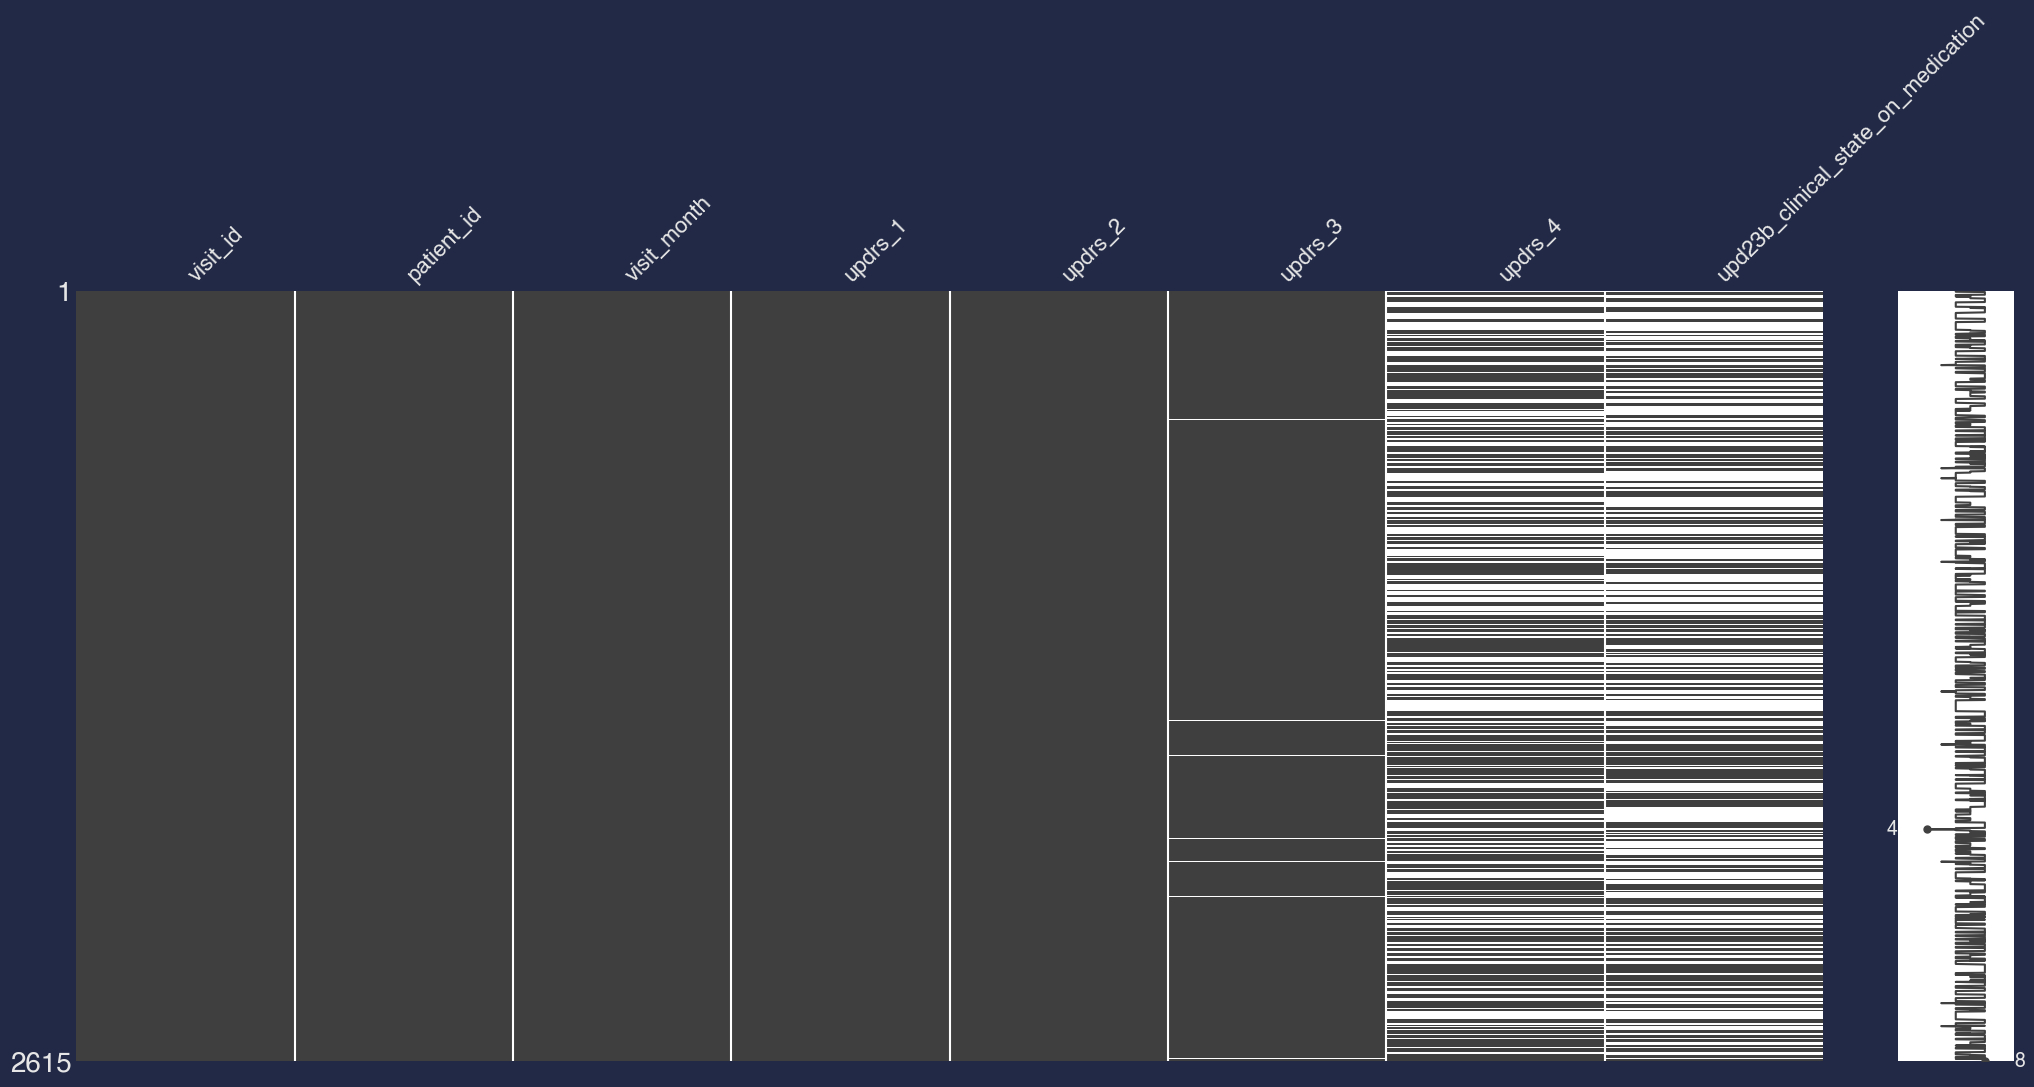

In [670]:
#missign values
msno.matrix(df)

In [671]:
## Note, the total possible points for each section are shown as the denomintors in the code below:
# df['updrs_1_frc'] = df['updrs_1'] / (13*4)
# df['updrs_2_frc'] = df['updrs_2'] / (13*4)
# df['updrs_3_frc'] = df[['updrs_3']] / (33*4)
# df['updrs_4_frc'] = df[['updrs_4']] / (6*4)
print("Maximum possible UPDRS score is", 13*4+13*4+33*4+6*4)

Maximum possible UPDRS score is 260


Many records are likely patients who do not have parkinsons. Perhaps in those patients with low total UPDRS scores and no Parkinson's, the UPDRS IV was not recorded. If we identify those patients, we can set the UPDRS IV = 0.

The mean total UPDRS score for the general popluation could be around 12.5 +- SD 9.5, according to 
*Mark R Keezer, Christina Wolfson, Ronald B Postuma (2016) https://pubmed.ncbi.nlm.nih.gov/26967747/*

Let's see what the distribution of UPDRS IV scores is for those with low total scores for UPDRS I-III

In [672]:
df = pd.read_csv('data/train_clinical_data.csv')


### Keep track of NaNs
df['updrs_4_na'] = df.updrs_4.isna()
df['updrs4_allna'] = False
df['updrs_3_na'] = df.updrs_3.isna()

df['updrs_1to3'] = df[['updrs_1','updrs_2','updrs_3']].sum(axis=1)


## Test hypothesis that low UPDRS I-III scores imply low UPDRS IV score

print("Distribution of UPDRS IV values for those records with sum of UPDRS I-III less than 15")
print(df[df['updrs_1to3']<=15].updrs_4.fillna('nan').value_counts())


Distribution of UPDRS IV values for those records with sum of UPDRS I-III less than 15
nan    529
0.0    179
4.0      7
1.0      3
3.0      2
2.0      2
5.0      2
Name: updrs_4, dtype: int64


So,
* A minority of records with UPDRS I-III < 15 have a non-zero UPDRS IV. 
* We will set all records with NaNs in IV to 0 if sum of I-III is less than 15
* For the remaining missing IV scores, imput by backward and forward interpolation, taking into account that only whole numbers are possible and that the interpolation must remain within records in time for a single patient (no interpolation between patients!).

### Imputing UPDRS IV

In [673]:
## If sum of all updrs from 1 to 3 is less than 3, then fill with updrs 4 with zeros
condition = (df['updrs_1to3']<=15) & df.updrs_4_na
df.updrs_4 = np.where(condition, 0., df.updrs_4)


### Fill remaining updrs_4 using forward and backfill
for patient in df.patient_id.unique():
    condition = (df.patient_id == patient)
    df.loc[condition,'updrs_4'] = df.loc[condition,'updrs_4'].fillna(method='ffill')
    df.loc[condition,'updrs_4'] = df.loc[condition,'updrs_4'].fillna(method='bfill')
    #Check if all a patient's updrs_4 records are 0, so that back and forward fill are of no use
    if df.loc[condition,'updrs_4'].isna().all():
        df.loc[condition,'updrs4_allna'] = True
    #print(df.loc[condition,['updrs_4','updrs_4_na']])


## Interpolate updrs_3
# Taking care not to cross boundaries between patients
# Respect conditions of up23d, whether on medication or not
#printvars= ['patient_id','visit_month','updrs_3','upd23b_clinical_state_on_medication']
for patient in df.patient_id.unique():
    condition = (df.patient_id == patient)
    if df.loc[condition,'updrs_3_na'].any():
        imax = len(df.loc[condition])
        for ii in range(1,imax+1):
                row = df.loc[condition][ii-1:ii]
                if (row['updrs_3_na'].values):
                    if (row['upd23b_clinical_state_on_medication'].isna().all()):
                        
                        df.loc[condition,'updrs_3'] = df.loc[condition,'updrs_3'].interpolate(limit_direction='both')
                        
                    else:
                        new_condition = condition & (df['upd23b_clinical_state_on_medication'] == row['upd23b_clinical_state_on_medication'].values[0]) 
                        
                        df.loc[new_condition,'updrs_3'] = df.loc[new_condition,'updrs_3'].interpolate(limit_direction='both')


## Interpolate the two remaining missing values updrs_2                       
#printvars= ['patient_id','visit_month','updrs_1','updrs_2','updrs_3','upd23b_clinical_state_on_medication']
for patient in df.patient_id.unique():
    condition = (df.patient_id == patient)
    if (df.loc[condition,['updrs_1','updrs_2']].isna().values.any()):
            df.loc[condition,['updrs_1','updrs_2']] = df.loc[condition,['updrs_1','updrs_2']].interpolate(
                  limit_direction='both',axis=0
            )

## Ensure that interpolation has not caused fractional values
for col in ['updrs_1','updrs_2','updrs_3','updrs_4']:
    df[col] = round(df[col])

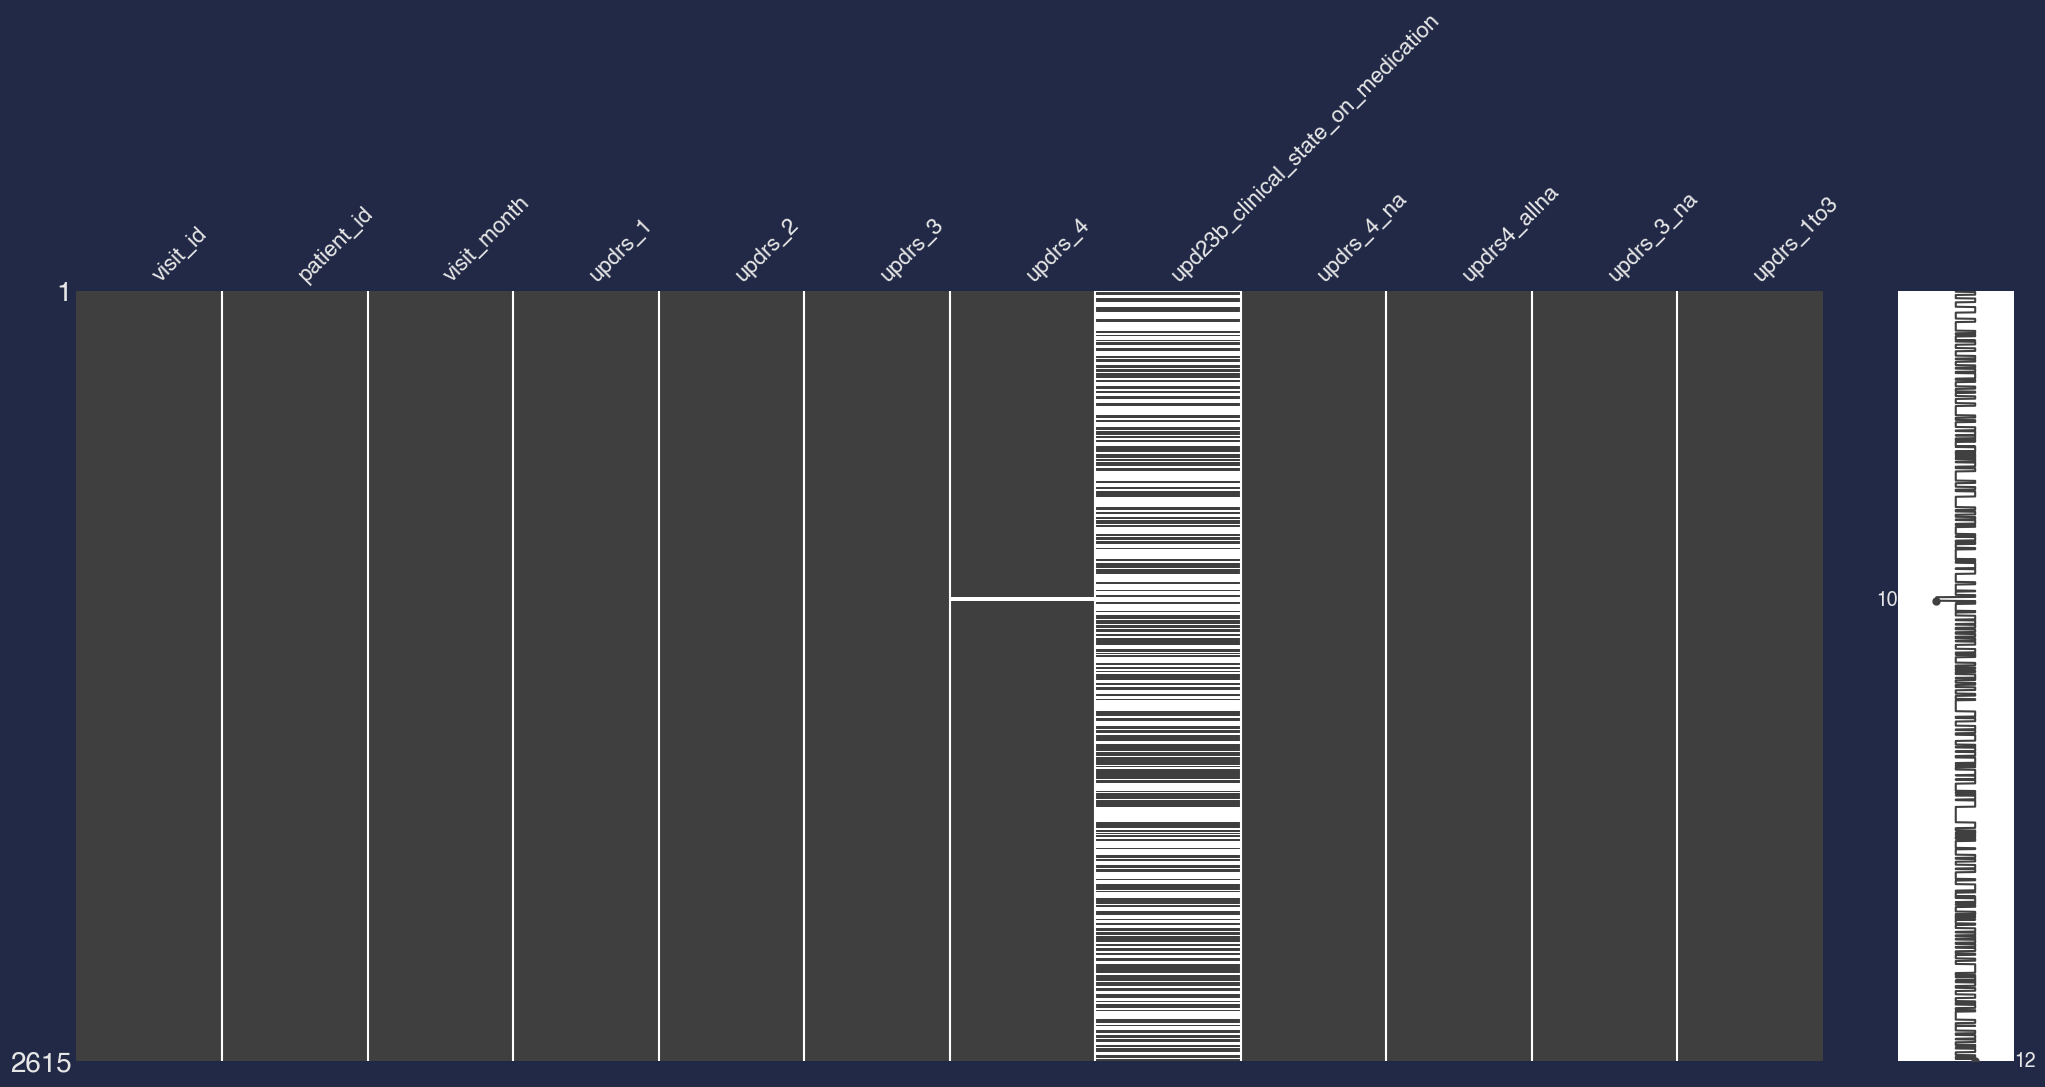

In [674]:
#Results after imputation
msno.matrix(df);

In [675]:
## Which patient records still have NaNs for UPDRS_4?
df[df.updrs_4.isna()]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_4_na,updrs4_allna,updrs_3_na,updrs_1to3
1039,24911_0,24911,0,9.0,7.0,14.0,NaN,NaN,True,True,False,30.0
1040,24911_3,24911,3,4.0,6.0,13.0,NaN,NaN,True,True,False,23.0
1041,24911_6,24911,6,5.0,6.0,14.0,NaN,NaN,True,True,False,25.0
1042,24911_9,24911,9,7.0,7.0,7.0,NaN,NaN,True,True,False,21.0
1043,24911_12,24911,12,11.0,5.0,26.0,NaN,NaN,True,True,False,42.0
1044,24911_18,24911,18,9.0,4.0,16.0,NaN,NaN,True,True,False,29.0
1045,24911_24,24911,24,11.0,8.0,19.0,NaN,NaN,True,True,False,38.0
1046,24911_30,24911,30,10.0,5.0,18.0,NaN,NaN,True,True,False,33.0
1047,24911_36,24911,36,10.0,6.0,20.0,NaN,NaN,True,True,False,36.0
1048,24911_42,24911,42,10.0,6.0,17.0,NaN,NaN,True,True,False,33.0


A single patient with id 24911, who has relatively high UPDRS I - III but no values for IV, should be discarded from the analysis. Since we cannot use "upd23b" for the prediction, and there are so many NaNs, let's drop this as well. Now we are NaN-free.

In [676]:
df.drop(df[df.patient_id == 24911].index, inplace=True)
df.drop('upd23b_clinical_state_on_medication', axis=1, inplace=True)

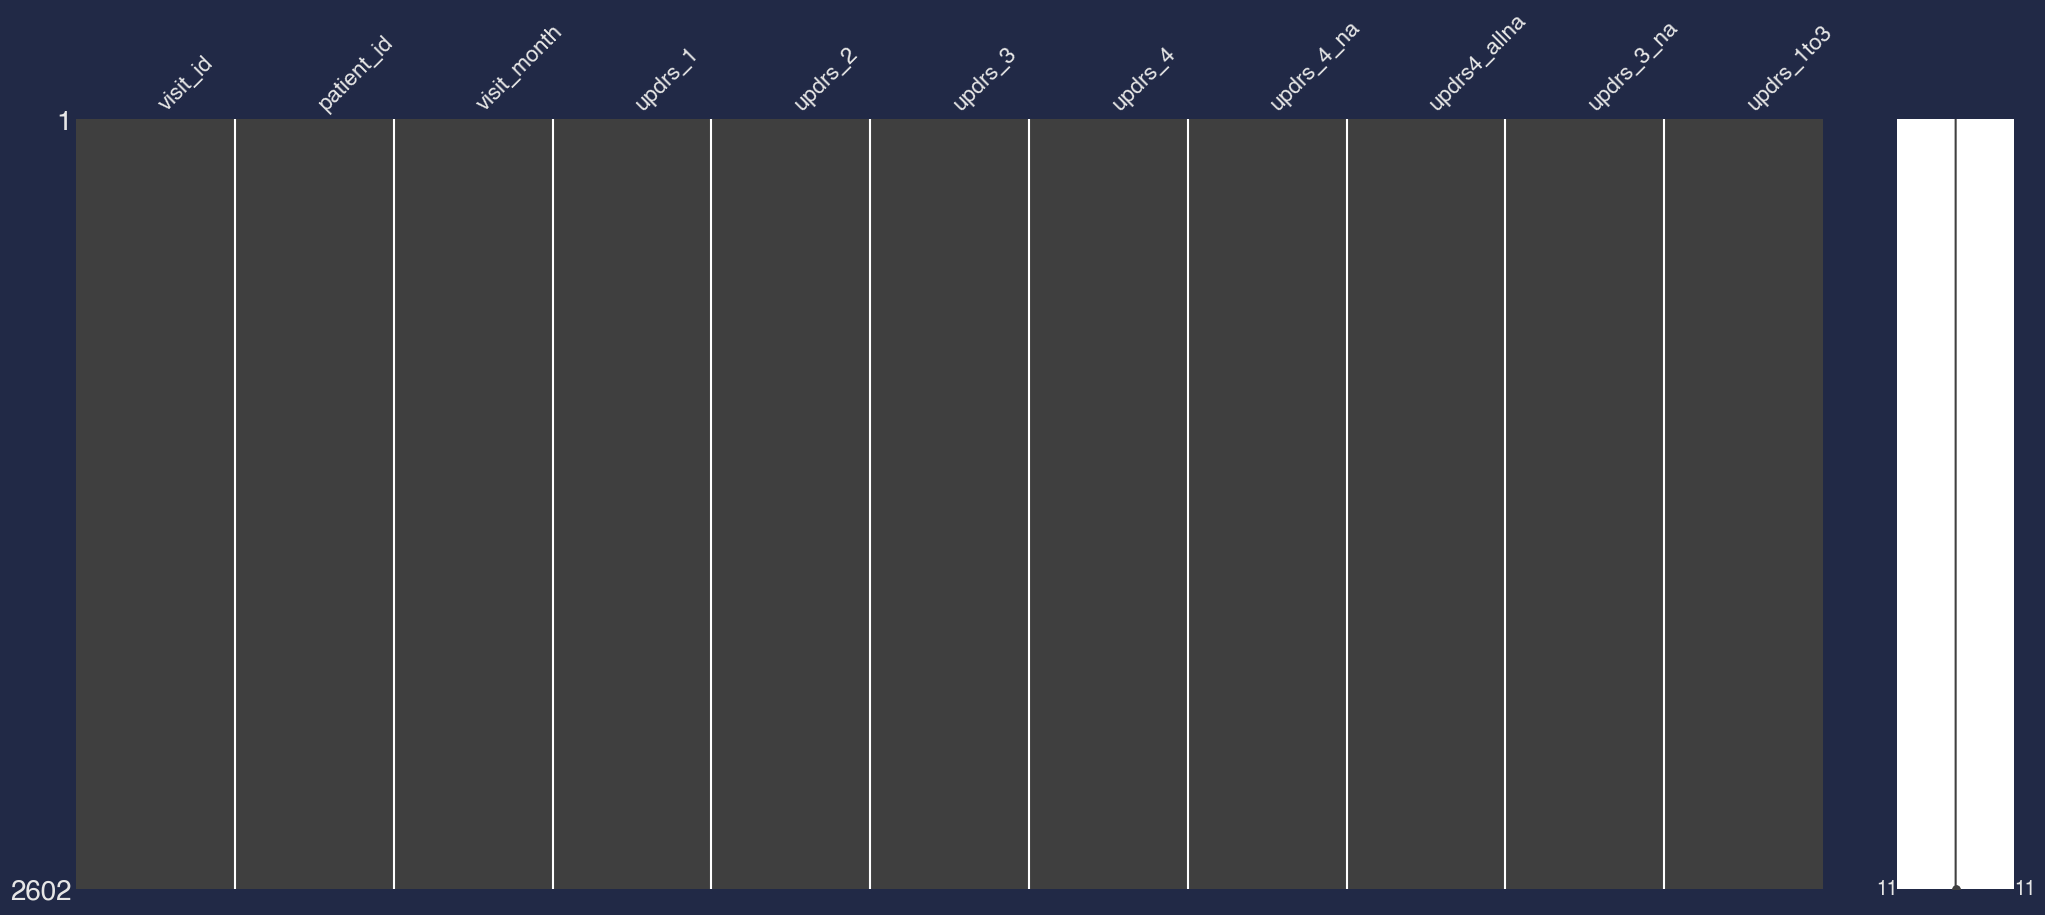

In [677]:
# Final results of imputation and cleaning
msno.matrix(df);

## Who has parkinsons?

We can try to identify who has Parkinson's and who doesn't in order to later check for differences in peptide concentrations netweem the two populations.

Anyone with a maximum total UPDRS less than 30 (out of 260) could considered to be a non-parkinsons patient. That represents two standard deviations from the population mean amongst healthy patients: 12.5 +- SD 9.5, according to *Mark R Keezer, Christina Wolfson, Ronald B Postuma (2016) https://pubmed.ncbi.nlm.nih.gov/26967747/*

Let's check the distribution to see if this makes sense.





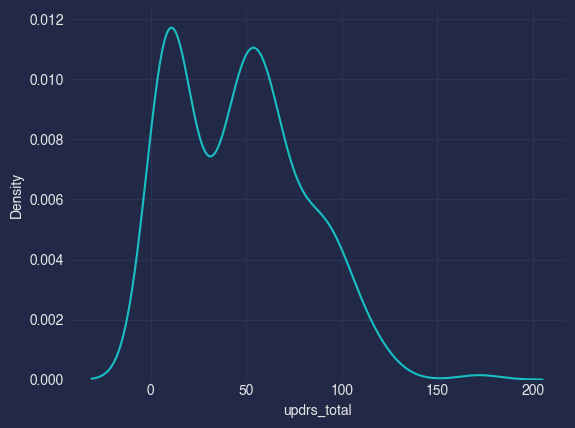

In [678]:
df['updrs_total'] = df['updrs_1'] + df['updrs_2'] + df['updrs_3'] + df['updrs_4']
max_updrs = df.groupby("patient_id",as_index=False).updrs_total.max()
max_updrs["park"] = max_updrs.updrs_total > 32

sns.kdeplot(max_updrs.updrs_total);

There is a bimodal distribution, with a local minimum around 30, which indicates that our suspicions were correct: there are two popluations of Parkinson's and control patients, and approximately 30 is a good threshold for separating them naively.

In [679]:
df = df.merge(max_updrs[["patient_id","park"]], right_on="patient_id", left_on="patient_id")

How do the UPDRS scores differe between the two populations?

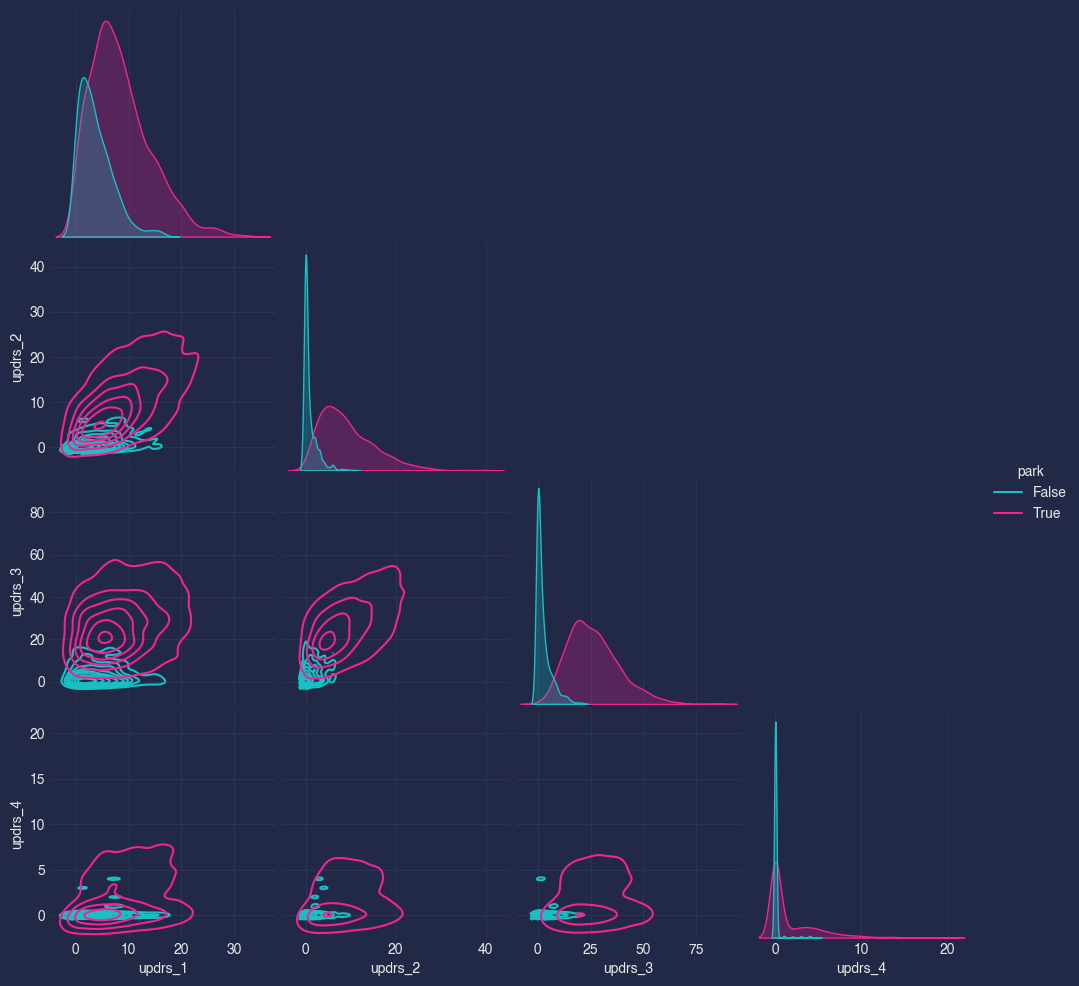

In [680]:
vars = ['updrs_1','updrs_2','updrs_3','updrs_4']
sns.pairplot(data=df,vars=vars,
             diag_kind='kde',corner=True, kind='kde',
             hue="park");

From this plot we can see that those patients without Parkinson's ("False") have very low values in UPDRS II-IV, but a broader range of values in UPDRS I, which stands for "evaluation of mentation, behavior, and mood". Cognitive ability and mood can be influenced by many factors besides Parkinson's, for example age.

In patients with Parkinson's, UPDRS I is correlated reasonably well with UPDRS II, II is more strongly correlated with III.
UPDRS IV is poorly correlated with the other factors.

 ## Peptides as predictors
 Does peptide concentration or peptide presence differ between Parkinson's and control patient groups? 

In [681]:
df_peptides.sort_values(by=["visit_id","Peptide"], axis=0)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
17305,10053_0,0,10053,P02766,AADDTWEPFASGK,6580710.0
17632,10053_0,0,10053,Q08380,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,31204.4
17312,10053_0,0,10053,P02768,AAFTEC(UniMod_4)C(UniMod_4)QAADK,7735070.0
17149,10053_0,0,10053,P01024,AAVYHHFISDGVR,46620.3
17313,10053_0,0,10053,P02768,ADDKETC(UniMod_4)FAEEGK,236144.0
...,...,...,...,...,...,...
175413,942_6,6,942,P10909,YVNKEIQNAVNGVK,80001.2
175070,942_6,6,942,P02753,YWGVASFLQK,79661.9
175210,942_6,6,942,P02790,YYC(UniMod_4)FQGNQFLR,573300.0
174901,942_6,6,942,P01024,YYTYLIMNK,48005.8


In [682]:
df_peptides.nunique()

visit_id              1113
visit_month             15
patient_id             248
UniProt                227
Peptide                968
PeptideAbundance    738931
dtype: int64

In [683]:
## Merge the UPDRS scores with the peptide concentrations
xx = df[["patient_id","park"]].drop_duplicates()
df_peptides = df_peptides.merge(xx, left_on="patient_id",right_on="patient_id",how="left")

In [684]:
## Calculate mean peptide concentration between the two populations, and the frequency with which the peptides are present
mean_peptide_park = df_peptides.groupby(["Peptide","park"],as_index=False).PeptideAbundance.mean()
count_peptide_park = df_peptides.groupby(["Peptide","park"],as_index=False).PeptideAbundance.count()

In [685]:
# Mean peptide concentration in the two populations
mean_peptide_park

,Peptide,park,PeptideAbundance
0,AADDTWEPFASGK,False,7.437918e+06
1,AADDTWEPFASGK,True,8.015617e+06
2,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,False,5.056279e+04
3,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,True,4.844583e+04
4,AAFTEC(UniMod_4)C(UniMod_4)QAADK,False,7.759427e+06
...,...,...,...
1931,YYC(UniMod_4)FQGNQFLR,True,4.729988e+05
1932,YYTYLIMNK,False,4.789515e+04
1933,YYTYLIMNK,True,4.645552e+04
1934,YYWGGQYTWDMAK,False,2.083826e+04


In [686]:
# Frequency of the peptides in each population
count_peptide_park.sort_values(["PeptideAbundance"])

,Peptide,park,PeptideAbundance
702,HYEGSTVPEK,False,208
410,EPQVYTLPPSRDELTK,False,214
1792,VPEEDLKR,False,223
1088,LTASAPGYLAITK,False,225
1270,QALPQVR,False,228
...,...,...,...
907,KYLYEIAR,True,685
183,AYQGVAAPFPK,True,685
825,KC(UniMod_4)STSSLLEAC(UniMod_4)TFR,True,685
1623,TLLSNLEEAK,True,685


In [687]:
df_peptides.Peptide.nunique()

968

There are 968 Peptides, but let's have a look at the difference in their distributions for parkinsons and non-parkinsons patients by taking the peptides with the greatest inter-sample differences.

### Differences in Peptides Concentrations

Which peptides have the strongest difference in mean concentration between both populations?

In [688]:
## Caculate the average proporational difference in peptide concentrations between both popultations as a percentage.
aa = mean_peptide_park.query('park == True').set_index('Peptide').PeptideAbundance
bb = mean_peptide_park.query('park == False').set_index('Peptide').PeptideAbundance

diff_pep_park = abs(2* (aa - bb) / (aa + bb)) * 100

diff_pep_park = diff_pep_park.sort_values(ascending=False)
diff_pep_park

Peptide
AYQGVAAPFPK                      21.971669
EDSLEAGLPLQVR                    21.829702
SEALAVDGAGKPGAEEAQDPEGK          19.093012
LRTEGDGVYTLNNEK                  18.810256
SGELEQEEER                       18.489728
                                   ...    
DVQLVESGGGLVKPGGSLR               0.030749
ALQDQLVLVAAK                      0.028035
LAVTTHGLPC(UniMod_4)LAWASAQAK     0.027777
TPLPPTSAHGNVAEGETKPDPDVTER        0.018092
VLNQELR                           0.013024
Name: PeptideAbundance, Length: 968, dtype: float64

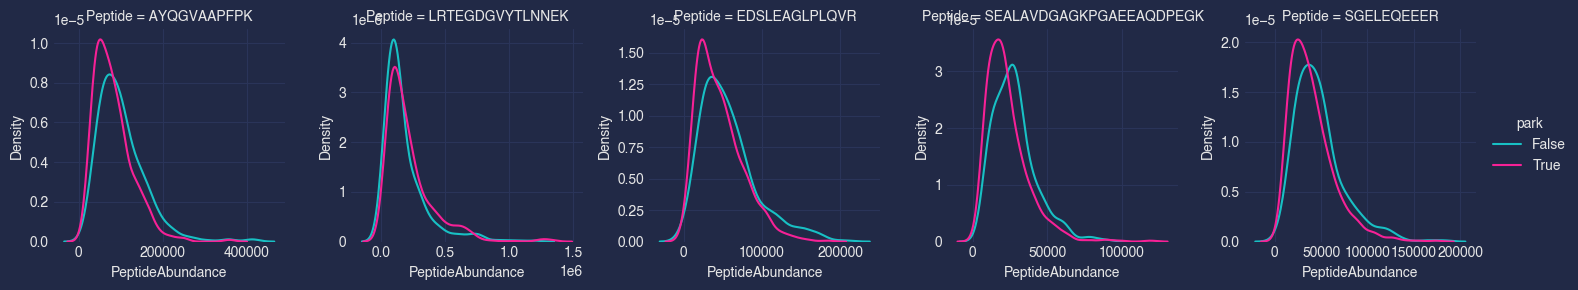

In [689]:
## Plot the top 5 peptides with largest difference in concentrations
diff_pep_park = diff_pep_park.sort_values(ascending=False)
peptides = list(diff_pep_park.index)
pep_iter = iter(peptides)
list_peptides = list(islice(pep_iter, 5))

g = sns.FacetGrid(df_peptides.query('Peptide in @list_peptides'), hue='park', col='Peptide',
                  sharex=False, sharey=False)
g.map(sns.kdeplot, 'PeptideAbundance');
g.add_legend();

There seems to be some difference between the two populations but the evidence is not overwhelming: there is a lot of overlap in peptides concentrations between patients from the Parkinson's and control group. Perhaps we are asking the wrong questions here.

Do we see a trend between UPDRS scores and peptide concentration? Check the join-probability distributions.

In [690]:
xx = df[["visit_id","updrs_total","updrs_1","updrs_2","updrs_3"]]
df_pep_updrs = df_peptides.query('Peptide in @list_peptides').merge(xx, left_on="visit_id", right_on="visit_id",how="inner")

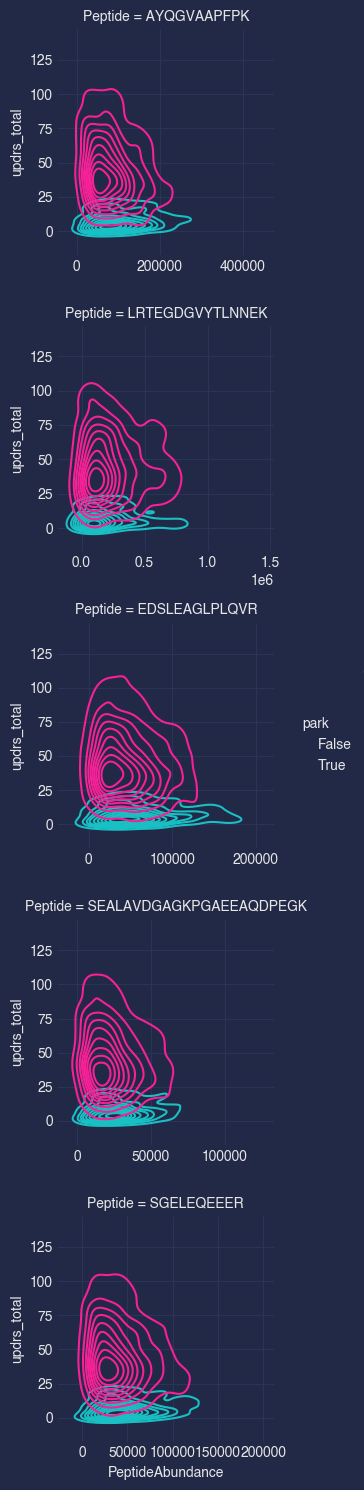

In [691]:
g = sns.FacetGrid(df_pep_updrs, hue='park', row='Peptide',
                  sharex=False, sharey=False)
g.map(sns.kdeplot, 'PeptideAbundance','updrs_total');
g.add_legend();

Hmph. There is hardly any correlation between peptide concentration and UPDRS. Let's check simply presence of peptides.

### Difference in Peptide presence / frequency

First find all the visits in which peptides were measured. Then check if there is a difference in UPDRS score between patients with a particular peptide, and those without.

In [692]:
## Show all visits where peptides are measured
all_visits = df_peptides.drop(["UniProt","Peptide","PeptideAbundance"],axis=1,inplace=False).drop_duplicates()
all_visits

,visit_id,visit_month,patient_id,park
0,55_0,0,55,True
931,1517_0,0,1517,True
1833,1923_0,0,1923,False
2710,2660_0,0,2660,False
3620,3636_0,0,3636,True
...,...,...,...,...
977292,58648_96,96,58648,False
978203,5645_108,108,5645,True
979096,12703_108,108,12703,False
980006,55096_108,108,55096,True


In [693]:
# Make a list of relevant visits
list_visits = list(df_peptides.visit_id.unique())

Calculate the peptides with the highest difference in frequency between the two popluations

In [694]:
## How many visits in total for the two populations?
park_visit_count = all_visits.groupby("park").visit_id.count()

# # Count the relative occurance of a peptide in measurements of cebebral spinal fluid
aa = count_peptide_park.query('park == True').set_index('Peptide').PeptideAbundance / park_visit_count[True] * 100
bb = count_peptide_park.query('park == False').set_index('Peptide').PeptideAbundance / park_visit_count[False] * 100


diff_pep_park = abs(aa - bb)

diff_pep_park = diff_pep_park.sort_values(ascending=False)
diff_pep_park

Peptide
QALPQVR                               15.963366
SLNNQIETLLTPEGSR                      14.831979
IC(UniMod_4)LEDNVLM(UniMod_35)SGVK    14.169536
EAEEETTNDNGVLVLEPARK                  14.146812
VAHQLQALR                             14.146467
                                        ...    
AIGYLNTGYQR                            0.000000
TLLSNLEEAK                             0.000000
KYLYEIAR                               0.000000
NILTSNNIDVK                            0.000000
IPTTFENGR                              0.000000
Name: PeptideAbundance, Length: 968, dtype: float64

Now construct a table with presence (false/true) of one of the significant peptides for a unique visit and the matching total UPDRS score. 

In [695]:
# Use the pivot table from before
df_peptides_[list_peptides].isna().head(3)

Peptide,AYQGVAAPFPK,EDSLEAGLPLQVR,SEALAVDGAGKPGAEEAQDPEGK,LRTEGDGVYTLNNEK,SGELEQEEER
visit_id,,,,,
10053_0,False,False,True,True,True
10053_12,False,False,True,True,True
10053_18,False,False,False,True,False


In [696]:
# Merge boolean table of a peptide presence with total UPDRS score
xx = df[["visit_id","updrs_total"]].query("visit_id in @list_visits")
xx.head(3)

df_peptide_occurance = df_peptides_[list_peptides].isna().merge(xx,left_index=True, right_on="visit_id", how="right")
df_peptide_occurance.head(3)

,AYQGVAAPFPK,EDSLEAGLPLQVR,SEALAVDGAGKPGAEEAQDPEGK,LRTEGDGVYTLNNEK,SGELEQEEER,visit_id,updrs_total
0,False,False,False,False,False,55_0,31.0
2,False,False,False,False,False,55_6,52.0
4,False,False,False,False,False,55_12,61.0


In [697]:
# Melt the table for easier plotting
df_peptide_occurance = df_peptide_occurance.drop(["visit_id",], axis=1).melt("updrs_total")
df_peptide_occurance.head(3)


,updrs_total,variable,value
0,31.0,AYQGVAAPFPK,False
1,52.0,AYQGVAAPFPK,False
2,61.0,AYQGVAAPFPK,False


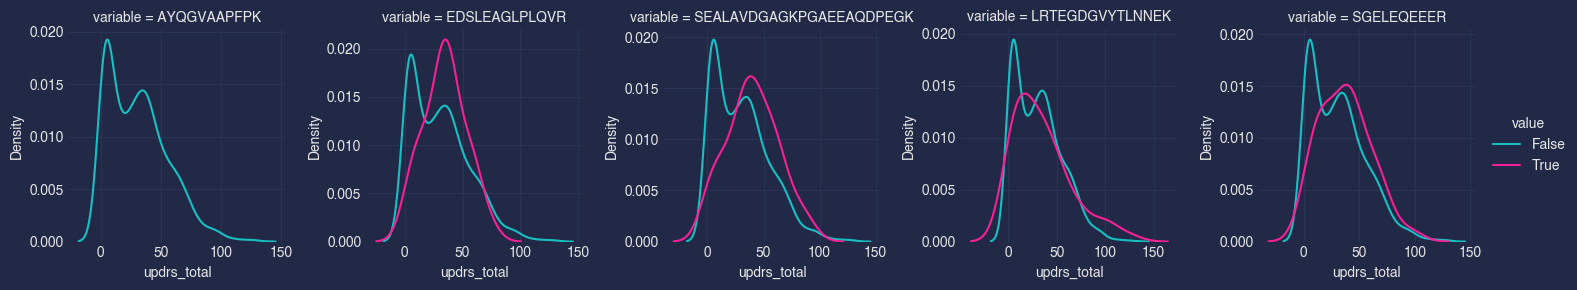

In [698]:
g = sns.FacetGrid(df_peptide_occurance, hue='value', col='variable',
                  sharex=False, sharey=False)
g.map(sns.kdeplot, 'updrs_total');
g.add_legend();

Wow, so there are clearly important differences in distribution of UPDRS, depending on the presence of some peptides. This means that we need a predictive method that can treat simple presence of a peptide (ignoring the concentration) as important for the prediction.  

Is there a correlation between peptide concentration and UPDRS total score for *these* peptides?

In [699]:
xx = df[["visit_id","updrs_total","updrs_1","updrs_2","updrs_3"]]
df_pep_updrs = df_peptides.query('Peptide in @list_peptides').merge(xx, left_on="visit_id", right_on="visit_id",how="inner")
df_pep_updrs.head(3)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,park,updrs_total,updrs_1,updrs_2,updrs_3
0,55_0,0,55,O15240,AYQGVAAPFPK,107076.0,True,31.0,10.0,6.0,15.0
1,55_0,0,55,P00738,LRTEGDGVYTLNNEK,187918.0,True,31.0,10.0,6.0,15.0
2,55_0,0,55,P10645,EDSLEAGLPLQVR,77231.5,True,31.0,10.0,6.0,15.0


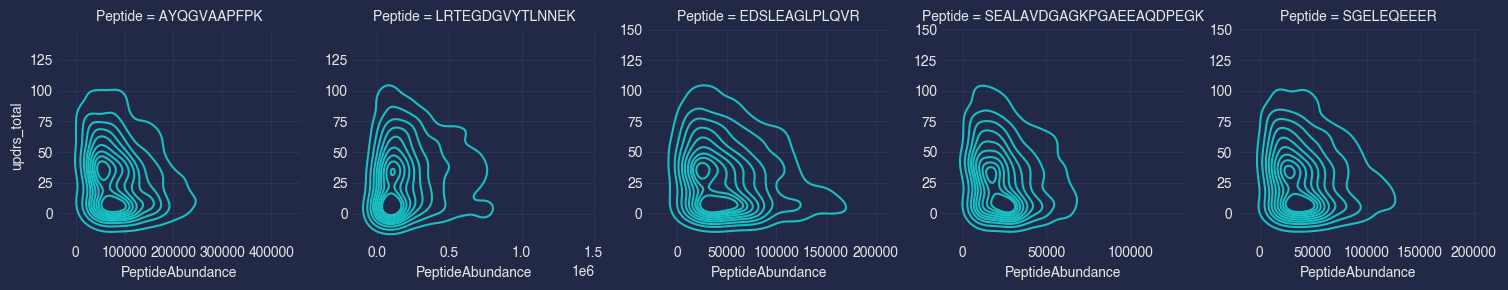

In [700]:
g = sns.FacetGrid(df_pep_updrs, col='Peptide',
                  sharex=False, sharey=False)
g.map(sns.kdeplot, 'PeptideAbundance','updrs_total');
g.add_legend();

*Sigh* no not really, there is no correlation between concentration of peptide and UPDRS. However, this could be an interesting criteria for exclusion of some features.

## Dimensionality reduciton: exclusion of features
I could exclude around 300 of 968 peptides which appear in most records (indicating ubiquity in Parkinson's patients and control patients), if their concentrations do not vary significantly with updrs_total, or if there is no significant difference in distribution between high and low updrs. I could extend this test for exclusion out to peptides that are in 95% of records.

More formally, I suggest three tests for exclusion of non-relevant peptide features.
1. Is the peptide present in 90% of all records?
2. Does presence of the peptide make a statistically significant difference to the population mean of updrs_total? Use Welche's t-test to account for differing variance in each population. Use a two-sided confidence interval of 90% so that test is slightly more permissive than normal.
3. Is there a statistically significant difference in the peptide concentration between populations with low updrs and high updrs? Again, use Welch's t-test and a two-sided CI of 90%.

If the peptide fails all these tests, throw it out!

Here is the number of peptides with % presence in all records:

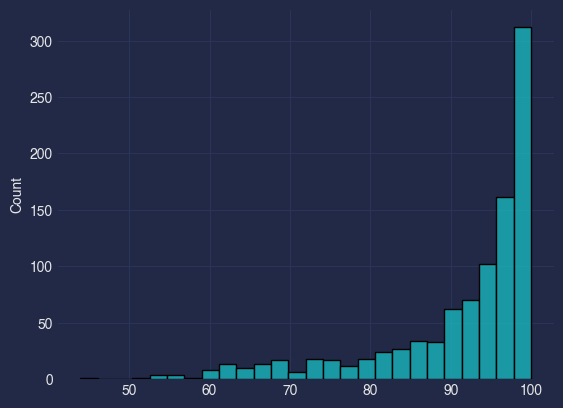

In [701]:
max_measurements = count_peptide_park.groupby("Peptide").PeptideAbundance.sum().max()
sns.histplot(count_peptide_park.groupby("Peptide").PeptideAbundance.sum().values / max_measurements * 100);

In [702]:
## Test 1 - calculate frequency
frequency_pep = count_peptide_park.groupby("Peptide").PeptideAbundance.sum() / max_measurements * 100
frequency_pep = frequency_pep.rename("Frequency")
frequency_pep.sort_values()

Peptide
QALPQVR                    43.913436
EPQVYTLPPSRDELTK           50.405771
TPSGLYLGTC(UniMod_4)ER     52.930568
SLEDQVEMLR                 53.832281
VPEEDLKR                   54.373309
                             ...    
IPTTFENGR                 100.000000
AIGYLNTGYQR               100.000000
NILTSNNIDVK               100.000000
TLLSNLEEAK                100.000000
KYLYEIAR                  100.000000
Name: Frequency, Length: 968, dtype: float64

In [703]:
## Test 2 - calculate Welch test for UPDRS total between populations with and without a peptide
updrs_total = df[["visit_id","updrs_total"]]

df_peptide_occurance = df_peptides_.isna().merge(updrs_total,left_index=True, right_on="visit_id", how="inner")
df_peptide_occurance = df_peptide_occurance.drop("visit_id", axis=1).melt("updrs_total")
df_peptide_occurance.head()


,updrs_total,variable,value
0,16.0,AADDTWEPFASGK,False
1,14.0,AADDTWEPFASGK,False
2,4.0,AADDTWEPFASGK,False
3,40.0,AADDTWEPFASGK,False
4,40.0,AADDTWEPFASGK,False


In [704]:

test2 = pd.Series(name="Test2_pvalue")
for peptide in peptides:
    test2[peptide] = scipy.stats.ttest_ind(
        df_peptide_occurance.query("(variable == @peptide) and (value == False)").updrs_total,
        df_peptide_occurance.query("(variable == @peptide) and (value == True)").updrs_total, equal_var=False
                                            ).pvalue

No. of samples with 'high' UPDRS:  176
No. of samples with 'low' UPDRS:  174


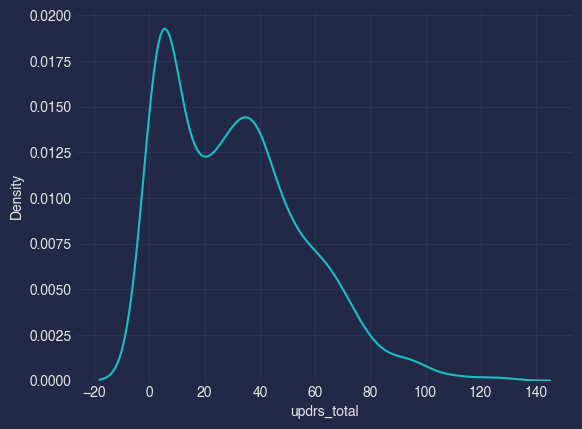

In [ ]:
#### Test 3 - calculate difference in peptide concetration between populations with high and low UPDRS
updrs_total_meas = updrs_total.query('visit_id in @list_visits')

sns.kdeplot(updrs_total_meas.updrs_total);

## Let's define high and low updrs like this, giving roughly balanced classes (see print statement)
updrs_total_meas['low'] = updrs_total_meas.updrs_total < 5
updrs_total_meas['high'] = updrs_total_meas.updrs_total > 55
print("No. of samples with 'high' UPDRS: ", updrs_total_meas['high'].sum())
print("No. of samples with 'low' UPDRS: ", updrs_total_meas['low'].sum())


In [ ]:
updrs_total_meas

,visit_id,updrs_total,low,high
0,55_0,31.0,False,False
2,55_6,52.0,False,False
4,55_12,61.0,False,True
8,55_36,86.0,False,True
15,942_6,31.0,False,False
...,...,...,...,...
2585,64674_84,75.0,False,True
2587,65043_0,24.0,False,False
2591,65043_12,25.0,False,False
2593,65043_24,20.0,False,False


In [ ]:
df_peptides_

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,6580710.0,31204.4,7735070.0,NaN,NaN,NaN,46620.3,236144.0,NaN,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,6333510.0,52277.6,5394390.0,NaN,NaN,NaN,57554.5,108298.0,45885.4,NaN,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.00,19787.3,36029.4,708729.0,5067790.0,30838.2,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,7404780.0,46107.2,10610900.0,NaN,20910.20,66662.3,55253.9,79575.5,6201210.0,26720.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.20,63672.7,36819.8,34160.9,2117430.0,15645.2,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,6312970.0,44462.7,12455000.0,11051.3,1163.18,43279.8,67743.5,325328.0,4666550.0,11038.5,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,11289900.0,46111.7,11297300.0,NaN,13894.10,53755.0,40289.3,565112.0,NaN,26495.8,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
942_24,10161900.0,32145.0,12388000.0,25869.2,17341.80,48625.5,45223.9,84448.0,4684800.0,23150.2,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [ ]:
df_peptide_concentration = df_peptides_.merge(updrs_total_meas,left_index=True, right_on="visit_id", how="inner")
df_conc_low = df_peptide_concentration.query('low == True')
df_conc_high = df_peptide_concentration.query('high == True')

df_conc_high.head()

,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_id,updrs_total,low,high
357,11955800.0,68167.9,7109360.0,21455.5,10965.5,52822.5,42010.4,430265.0,3067120.0,22309.5,...,1231820.0,105571.0,161194.0,725132.0,66307.7,28106.90,11459_0,60.0,False,True
363,8091690.0,51981.6,8163650.0,35160.1,17203.8,59096.1,45422.3,461374.0,7153030.0,33667.3,...,944128.0,106813.0,166025.0,486760.0,49798.3,21891.30,11459_36,65.0,False,True
473,14890300.0,79446.9,10093300.0,NaN,12664.5,102077.0,35895.1,459045.0,5681240.0,39687.4,...,241482.0,139968.0,87398.6,402363.0,42082.3,15276.30,13618_0,74.0,False,True
477,14159300.0,40707.3,9860170.0,NaN,10434.9,46459.4,33451.3,512781.0,NaN,32912.6,...,120563.0,107514.0,77566.7,305990.0,32409.7,2954.66,13618_12,73.0,False,True
479,16541700.0,43946.3,10382300.0,NaN,13755.9,35997.6,30762.3,538771.0,7906340.0,35315.3,...,155973.0,107159.0,74918.2,336098.0,33849.9,NaN,13618_24,103.0,False,True


In [ ]:
test3 = pd.Series(name="Test3_pvalue")

for peptide in peptides:
    test3[peptide] = scipy.stats.ttest_ind(
        df_conc_high[peptide],
        df_conc_low[peptide], 
        equal_var=False, nan_policy='omit'
                                            ).pvalue
    
test3

AYQGVAAPFPK                      0.000004
EDSLEAGLPLQVR                    0.000765
SEALAVDGAGKPGAEEAQDPEGK          0.000194
LRTEGDGVYTLNNEK                  0.079673
SGELEQEEER                       0.000023
                                   ...   
DVQLVESGGGLVKPGGSLR              0.313370
ALQDQLVLVAAK                     0.205548
LAVTTHGLPC(UniMod_4)LAWASAQAK    0.799932
TPLPPTSAHGNVAEGETKPDPDVTER       0.189502
VLNQELR                          0.147487
Name: Test3_pvalue, Length: 968, dtype: float64

In [ ]:
### Concatenate the values and perform the test
test_results = pd.merge(frequency_pep,test2, left_index=True, right_index=True)
test_results = pd.merge(test_results, test3, left_index=True, right_index=True)

test_results.query('(Frequency > 0.90) and (Test2_pvalue > 0.1) and (Test3_pvalue > 0.1)')

,Frequency,Test2_pvalue,Test3_pvalue
AADDTWEPFASGK,96.032462,0.912108,0.269436
AAVYHHFISDGVR,94.319206,0.907578,0.489172
ADDKETC(UniMod_4)FAEEGK,98.917944,0.948157,0.971406
ADLSGITGAR,99.368801,0.370645,0.830663
AFPALTSLDLSDNPGLGER,94.229035,0.143213,0.248081
...,...,...,...
YLFLNGNK,94.770063,0.762520,0.269653
YSLTYIYTGLSK,98.827773,0.203976,0.167564
YVGGQEHFAHLLILR,91.794409,0.849467,0.775497
YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,87.736700,0.258552,0.201840


In [ ]:
### Output the peptides to exclude
exclude = list(test_results.query('(Frequency > 0.90) and (Test2_pvalue > 0.1) and (Test3_pvalue > 0.1)').index)
## Output the peptides to include as binary features (present or not present) 
presence = list(test_results.query('Test2_pvalue < 0.1').index)
## From the remaining peptides, output those should be included as numeric features
concentration = list(test_results.query('(Test2_pvalue >= 0.1) and (Test3_pvalue < 0.1)').index)


In [ ]:
#Binary presence features
len(presence)

300

In [ ]:
#Numeric features
len(concentration)

282

So we are down to 582 features, 300 of which will be binary. Not bad, we have reduced the number of dimensions by almost 400 and reduced the feature complexity in 300 cases. Now to the prediction model and the next notebook.